# Fully Convolutional Networks for Semantic Segmentation

- 此CNN模型，去掉了最后的全连接层和全局平均池化层
- 1x1 conv和转置卷积层是FCN新加的
    - 1x1 conv不对空间信息做变化，只用来降低通道数，为了降低后面的计算量
    - 转置卷积层把图片放大
        - 假如CNN把ImageNet图片(224x224)高宽缩小32倍，至7x7
        - 转置卷积层会把7x7图片扩大32倍，还原至224x224
        - 通道数K等于类别数。对每个像素的预测，存在通道里面
        - 这样就能对每个像素做预测
<img src="./pic/FCN.PNG" width=400 height=400>


In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

- 使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征，并将该网络记为pretrained_net。 ResNet-18模型的最后几层包括全局平均汇聚层和全连接层，然而全卷积网络中不需要它们。

In [3]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]
# 把最后的3层列出来。倒数2层不需要

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

# 创建一个全卷积网络net

In [4]:
# 把最后两层去掉，只保留前面的模型
net = nn.Sequential(*list(pretrained_net.children())[:-2])

X = torch.rand(size=(1, 3, 320, 480))
# 从resnet拿过来，抽feature的模型
net(X).shape
# 缩小32倍

C:\Users\Tyler\anaconda3\envs\pytorch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 512, 10, 15])

- 使用卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。 
    - 1类为背景类
- 再将特征图的高度和宽度增加32倍，从而将其变回输入图像的高和宽。
    - 在卷积中，若要保持输出与输入的高宽相等：
        - 步长s = 1
        - $(H_{in} - k + 2P +s) \div s = H_{out}$
        - $k - 2p - 1 = 0$
        - 假设k为奇数，$p = (k-1)/2$；
        - 假设k为偶数，$p = k/2$。就能保持输出的高宽等于输入的高宽
    - 在转置卷积中。若要保持输出与输入的高宽相等：
        - 步长s = 缩小的倍数
        - $(H_{in} - 1) \times s - 2p + k = H_{out}$
        - $s - 2p + k = 0$
        - 令$s=32, k=64$，则$p=16$

In [5]:
# VOC有21类
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))    # 直接降到21维，精度有损失，但速度快
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))
# 因为要把图片放大32倍，所以stride=32。kernel和paddaing的尺寸要尽量保持高宽不变

# 初始化转置卷积层

- 在图像处理中，我们有时需要将图像放大，即上采样（upsampling）。 双线性插值（bilinear interpolation） 是常用的上采样方法之一，它也经常用于初始化转置卷积层。

- 解释双线性插值：
    - 假设给定输入图像，我们想要计算上采样输出图像上的每个像素。 
    - 首先，将输出图像的坐标$(x, y)$映射到输入图像的坐标$(x', y')$上。 
        - 例如，根据输入与输出的尺寸之比来映射。 注意，映射后的$x'$和$y'$是实数。 
    - 然后，在输入图像上找到离坐标$(x', y')$最近的4个像素。 
    - 最后，输出图像在坐标$(x, y)$上的像素依据输入图像上这4个像素及其与$(x', y')$的相对距离来计算。

- 双线性插值的上采样可以通过转置卷积层实现，内核由以下bilinear_kernel函数构造

In [6]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

# 这是的双线性插值只是为了初始化转置卷积的权重参数，没有其他意义

### 双线性插值的上采样实验

- 用双线性插值的上采样实验它由转置卷积层实现。 我们构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用bilinear_kernel函数初始化。

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


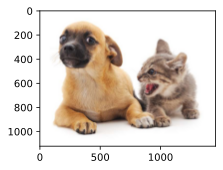

In [8]:
# stride=2  => 将输入的高和宽放大2倍
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)

# 使用双线性核初始化权重
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))

img = torchvision.transforms.ToTensor()(d2l.Image.open('./pic/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()


d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

- 用双线性插值的上采样初始化转置卷积层。对于1x1卷积层，我们使用Xavier初始化参数。

In [9]:
# 转置卷积初始化 = 转置卷积 + 双线性插值(权重参数)
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

## 读取数据集

In [10]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


# 训练

loss 0.416, train acc 0.870, test acc 0.853
100.9 examples/sec on [device(type='cuda', index=0)]


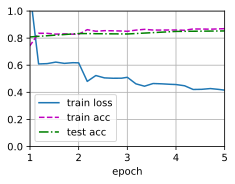

In [11]:
def loss(inputs, targets):
    # 对图片的高和宽都要做预测，所以是个矩阵（以前只是个标量）。
    # 在高和宽都做均值，这样就只用拿到1个值
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

# 精度：大部分像素的中间部分的分类很简单，但在物体边缘处的像素很难。
# 所以在绝大多数简单的情况下，精度应该很高。0.87在边缘处理的部分，不是很好

# 预测

In [12]:
def predict(img):
    # 对测试集的RGB做normalize
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    # 在通道维做argmax，因为每一个像素，有21通道，返回预测最大的通道的标号
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

## 可视化预测的类别

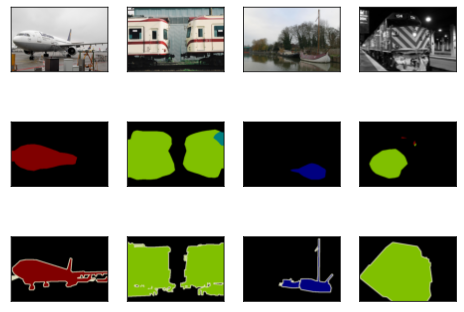

In [15]:
# 传入每个像素的预测值，把预测值变成Image
def label2image(pred):
    # VOC_COLORMAP：把每个类别的RGB值做成tensor
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    # 把预测值做成一个index
    X = pred.long()
    # 返回预测的RGB值
    return colormap[X, :]


voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)    # 在左上角剪裁
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2)

# 第二行预测
# 第三行真实
# 物体主体还行，但丢失的精度，就是边缘像素

# FCN总结：

把卷积神经网络的最后两层（全连接层和全局平均池化层）去掉，换成一个转置卷积层，还原之前缩小的倍数（假如之前网络把高宽缩小32倍，转置卷积层则要扩大32倍），可以得到每个像素的预测。输出的通道数就是标号的类别数，每个像素都能得到类别的预测。为了降低最后一层的计算量，转置卷积层之前可以添加$1 \times 1$卷积层